# Set Up Google Colab and Import Dependencies

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


2024-10-15 08:22:22.886176: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 08:22:22.894961: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 08:22:22.930438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 08:22:22.993351: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 08:22:23.011310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 08:22:23.048848: I tensorflow/core/platform/cpu_feature_gu

# Download and Prepare the MNIST Dataset

In [10]:
# Load the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the input data to [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Flatten the images for the fully connected layers
x_train = x_train.reshape((len(x_train), 28 * 28))
x_test = x_test.reshape((len(x_test), 28 * 28))

# Reduce the size of the dataset
reduced_size_train = int(len(x_train) * 0.3)
reduced_size_test = int(len(x_test) * 0.2)

# Randomly sample from the dataset
x_train = x_train[:reduced_size_train]
x_test = x_test[:reduced_size_test]

# Split the training data into training and validation sets (80% training, 20% validation)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=42)

# Output the new shapes to verify the reduction and split
print(f"Reduced training data shape: {x_train.shape}")
print(f"Validation data shape: {x_val.shape}")
print(f"Reduced testing data shape: {x_test.shape}")


Reduced training data shape: (19200, 784)
Validation data shape: (4800, 784)
Reduced testing data shape: (2000, 784)


# Define the KL Divergence Loss Function

In [5]:
# Define the KL divergence loss function for sparsity with epsilon to avoid log(0)
def kl_divergence(rho, rho_hat, epsilon=1e-10):
    # Add a small value (epsilon) to avoid log(0) in the KL divergence calculation.
    rho_hat = K.clip(rho_hat, epsilon, 1 - epsilon)  # Clip values to avoid log(0)
    return K.sum(rho * K.log(rho / rho_hat) + (1 - rho) * K.log((1 - rho) / (1 - rho_hat)), axis=-1)



# Build the Sparse Autoencoder Model

In [6]:
# Parameters
input_dim = x_train.shape[1] 
encoding_dim = 784
rho = 0.05  # Desired average activation of hidden units

# Build the sparse autoencoder model
input_img = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = models.Model(input_img, decoded)
encoder = models.Model(input_img, encoded)

# Display the model summary
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 784)            │       402,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 804,112 (3.07 MB)

 Trainable params: 804,112 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

# Define the Custom Loss Function

In [7]:
# Define the custom loss function that includes the KL divergence
def sparse_ae_loss(x_true, x_pred):
    loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x_true, x_pred))
    # Get the activations of the hidden layer
    encoded_output = encoder(x_true)
    # Calculate the average activation for each hidden unit
    rho_hat = K.mean(encoded_output, axis=0)
    # Add the KL divergence term
    kl_loss = kl_divergence(rho, rho_hat)
    return loss + kl_loss

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0) 
autoencoder.compile(optimizer=optimizer, loss=sparse_ae_loss)


# Train the Model

In [11]:
# Train the model
history = autoencoder.fit(x_train, x_train,
                          epochs=20,
                          batch_size=64,
                          shuffle=True,
                          validation_data=(x_val, x_val))


Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 210ms/step - loss: 1.2767 - val_loss: 1.2578
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 62s 207ms/step - loss: 1.2629 - val_loss: 1.2477
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 62s 205ms/step - loss: 1.2225 - val_loss: 1.2538
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 60s 201ms/step - loss: 1.2222 - val_loss: 1.1964
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 58s 194ms/step - loss: 1.1836 - val_loss: 1.2253
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 56s 187ms/step - loss: 1.1702 - val_loss: 1.1942
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 195ms/step - loss: 1.1743 - val_loss: 1.1689
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 55s 182ms/step - loss: 1.1639 - val_loss: 1.1490
Epoch 9/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 56s 187ms/step - loss: 1.1252 - val_loss: 1.1443
Epoch 10/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 195ms/step - loss: 1.1139 - val_loss: 1.1405
Epoch 11/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 194ms/step - loss: 1.1265 - val_loss: 1.1236
Epoch 12/20
300/300

# Evaluate the Autoencoder and Perform Inference

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


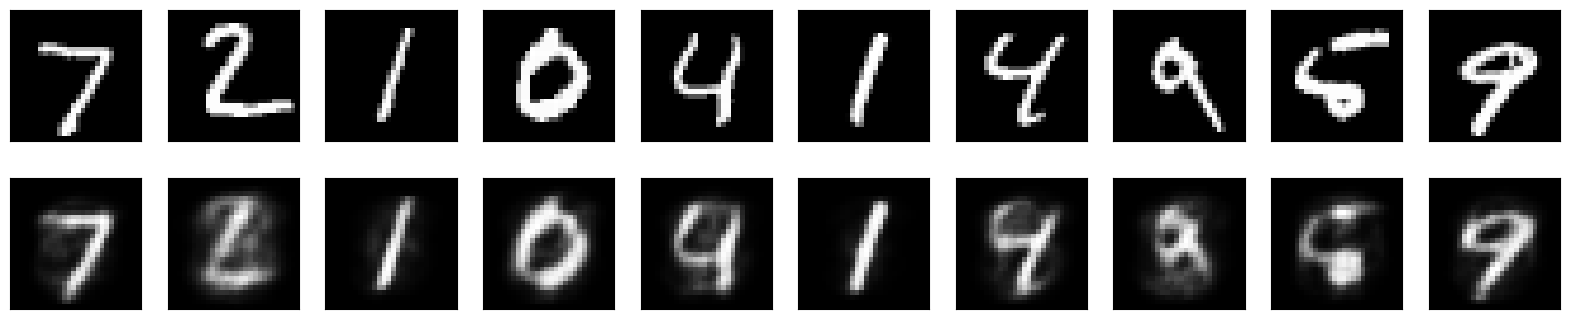

In [12]:
# Evaluate the model
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

# Plot some of the original and reconstructed images
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
